In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

### Import data

In [2]:
merged_simulated = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_up.csv'),
                    index_col=0)
merged_simulated

,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp,type_cw
KJIC,,,,,,,,,,,,,,
104.509264,1.065855,0.327941,0.389267,-1.381644,0.053704,0.001991,0.834178,0.020991,3.214580,0.572778,0.014074,1.923546,7.903716,304-40
121.243211,0.527884,0.072630,0.192897,-1.338246,0.049170,0.002014,0.790009,0.017016,3.217831,0.514249,0.013415,2.044493,9.467436,304-40
79.715363,0.043292,0.034634,0.024251,-1.726655,0.044679,0.002272,0.905257,0.014341,1.586630,0.889712,0.017395,0.941155,4.245708,316-60
64.051840,0.019697,0.028520,0.011775,-1.617859,0.045108,0.002848,0.743794,0.024531,4.418423,0.568634,0.004623,0.690947,13.192833,316-20
73.157311,1.674169,0.706512,0.975727,-1.163593,0.050287,0.002355,0.936776,0.030000,4.412032,0.734233,0.014353,2.847758,10.842438,347-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103.656045,0.903747,0.293774,0.663192,-1.366847,0.050597,0.001837,0.793925,0.012903,2.922287,0.534626,0.016181,2.236833,8.944160,304-40
73.563492,0.235263,0.121622,0.337979,-1.323185,0.051098,0.002270,0.905553,0.006000,0.800004,0.816819,0.015096,2.161126,11.757315,347-40
195.852151,0.009489,0.002000,0.002000,-1.315298,0.044993,0.002295,0.188705,0.008758,4.360779,0.305240,0.003606,1.996722,8.618148,A286-0


## Select columns of interest

In [3]:
mean_df = merged_simulated.copy()
cw_regex = re.compile("[0-9]+$") 
cold_work = [str(re.search(cw_regex,x).group()) for x in mean_df.type_cw ]
mean_df['KJIC'] = mean_df.index
cw_regex = re.compile("^[A]*[0-9]+") 
mean_df.index = [str(re.search(cw_regex,x).group()) for x in mean_df.type_cw ]
mean_df = mean_df[["KJIC","MS_Avg","TEP_average","Beta_avg","IF_amp_2.25MHz","IF_amp_3.5MHz","BS_amp"]]
mean_df['log_MS_Avg'] = np.log(mean_df['MS_Avg'])
mean_df['log_beta_avg'] = np.log(mean_df['Beta_avg']) 
log_kjic = np.log(mean_df.KJIC)
mean_kjic = mean_df.KJIC
mean_df.drop(columns=['KJIC','MS_Avg','Beta_avg'], inplace=True)
mean_df

,TEP_average,IF_amp_2.25MHz,IF_amp_3.5MHz,BS_amp,log_MS_Avg,log_beta_avg
304,-1.381644,0.834178,0.572778,7.903716,0.063777,-6.219122
304,-1.338246,0.790009,0.514249,9.467436,-0.638879,-6.207786
316,-1.726655,0.905257,0.889712,4.245708,-3.139785,-6.087111
316,-1.617859,0.743794,0.568634,13.192833,-3.927307,-5.860981
347,-1.163593,0.936776,0.734233,10.842438,0.515317,-6.051243
...,...,...,...,...,...,...
304,-1.366847,0.793925,0.534626,8.944160,-0.101206,-6.299407
347,-1.323185,0.905553,0.816819,11.757315,-1.447049,-6.088029
A286,-1.315298,0.188705,0.305240,8.618148,-4.657654,-6.076902
316,-1.478194,0.475078,0.547826,9.722967,-3.848919,-6.069059


## Scale data

In [4]:
scaled_df = mc.scale_general(mean_df, MinMaxScaler())[0]
scaled_df.index = mean_df.index
scaled_df["cold_work"] = cold_work
scaled_kjic = mc.scale_general(pd.DataFrame(mean_kjic), MinMaxScaler())[0]
scaled_kjic.index = mean_df.index
scaled_df

,TEP_average,IF_amp_2.25MHz,IF_amp_3.5MHz,BS_amp,log_MS_Avg,log_beta_avg,cold_work
304,0.430602,0.399905,0.102356,0.391417,0.726047,0.313547,40
304,0.470641,0.375614,0.089744,0.496761,0.618574,0.333589,40
316,0.112296,0.438994,0.170650,0.144986,0.236057,0.546948,60
316,0.212671,0.350199,0.101463,0.747732,0.115605,0.946759,20
347,0.631776,0.456328,0.137147,0.589392,0.795110,0.610365,60
...,...,...,...,...,...,...,...
304,0.444254,0.377768,0.094135,0.461510,0.700812,0.171598,40
347,0.484536,0.439157,0.154943,0.651025,0.494963,0.545327,40
A286,0.491813,0.044931,0.044707,0.439547,0.003897,0.564999,0
316,0.341525,0.202420,0.096979,0.513976,0.127594,0.578865,0


### PCA

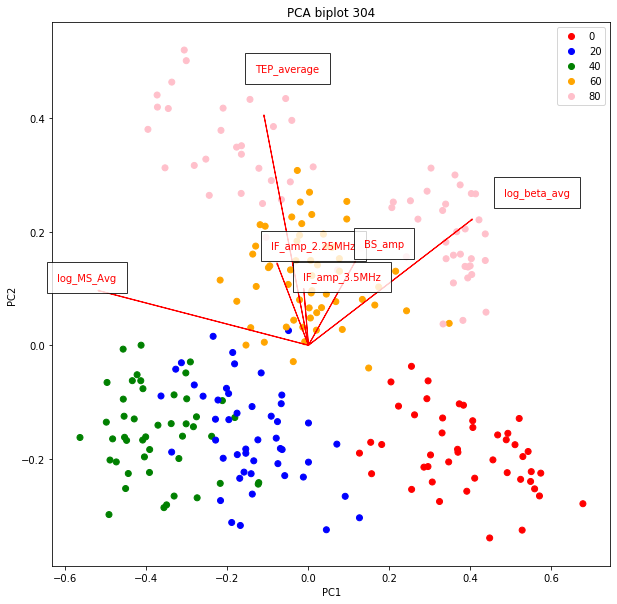

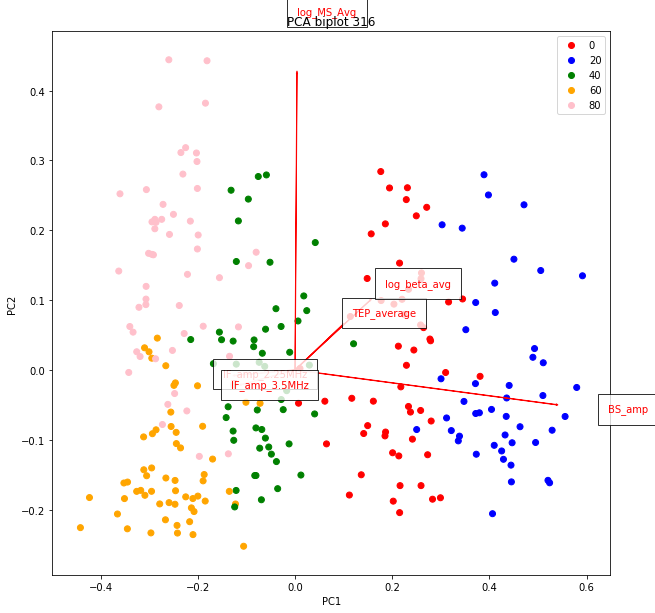

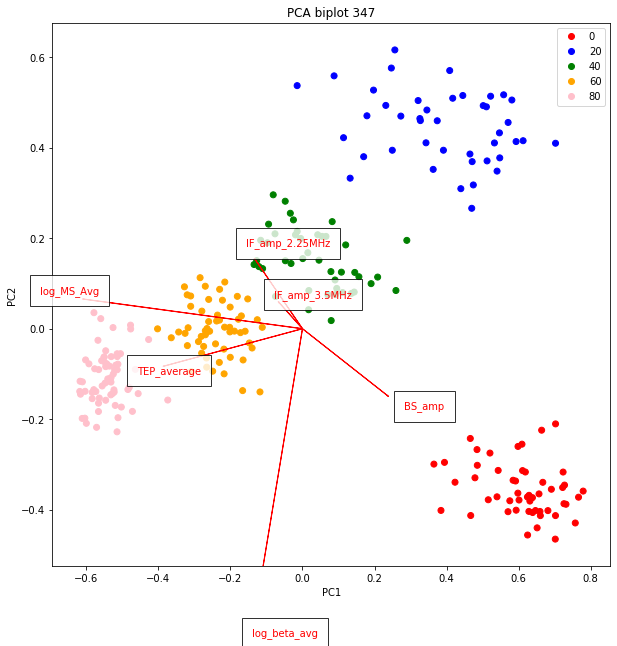

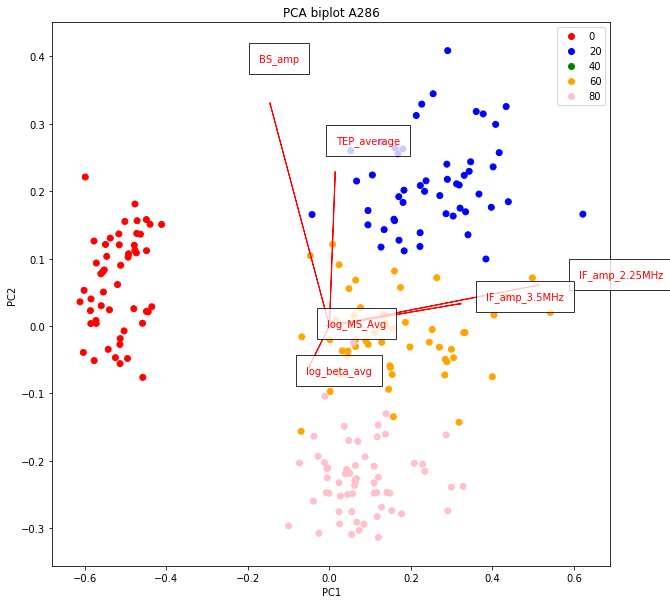

In [5]:
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_dr.index = subset_dr.cold_work
    subset_dr.drop(columns=['cold_work'],inplace=True)
    pca = PCA(n_components=4, svd_solver='full')
    pca.fit(subset_dr)
    color_dict = { '0':'red', '20':'blue', '40':'green', '60':'orange', '80':'pink' }
    mc.biplot(pca, subset_dr, 0, 1, "PCA biplot "+ind, color_dict)    

### "Regression" models

At this point a regression is pointless but it would be a linear regression so instead I'll just plot it and you can eyeball it to see what a fit line would behave like. Well 304 and 316 look linear with TEP, MS, and IF contributing.

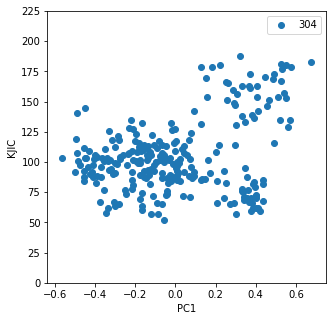

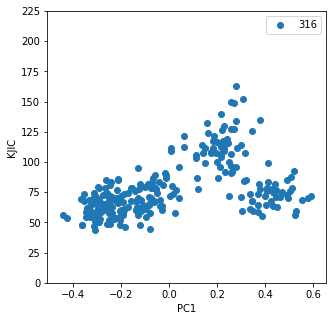

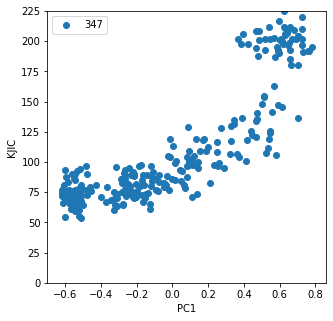

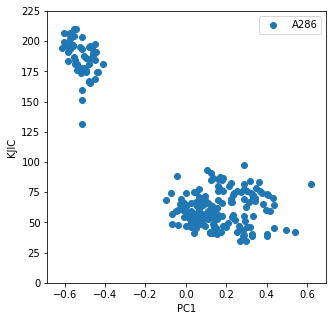

In [6]:
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_kjic = mean_kjic[mean_kjic.index==ind].copy()
    true_Y = subset_kjic
    subset_dr.drop(columns=['cold_work'],inplace=True)
    pca = PCA(n_components=1, svd_solver='full')
    xs = pca.fit_transform(subset_dr)
    plt.figure(figsize=(5, 5))
    plt.scatter(xs, true_Y, label=ind)
    plt.ylim(0,225)
    plt.xlabel('PC1')
    plt.ylabel('KJIC')
    plt.legend()


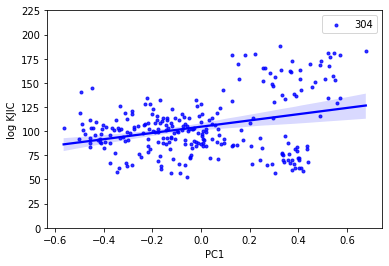

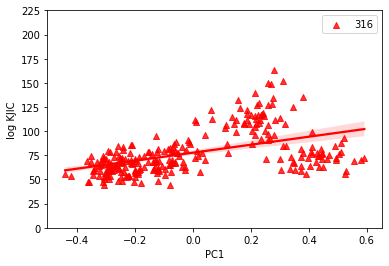

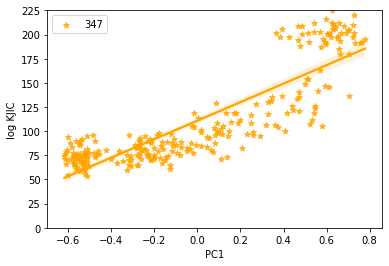

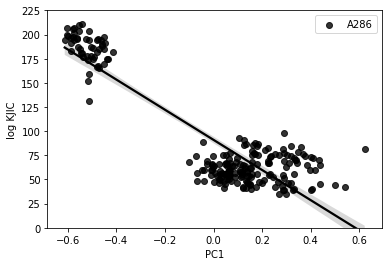

In [11]:
colors=['blue','red','orange','black']
markers=['.','^','*','o']
i=0
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_kjic = mean_kjic[mean_kjic.index==ind].copy()
    true_Y = subset_kjic
    subset_dr.drop(columns=['cold_work'],inplace=True)
    pca = PCA(n_components=1, svd_solver='full')
    xs = pca.fit_transform(subset_dr)
    plt.figure()
    sns.regplot(xs, subset_kjic, scatter=True, fit_reg=True, color=colors[i], label=ind,marker=markers[i])
    plt.ylim(0,225)
    plt.xlabel('PC1')
    plt.ylabel('log KJIC')
    plt.legend()
    i+=1


### Feature importance

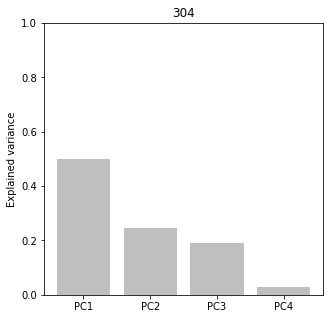

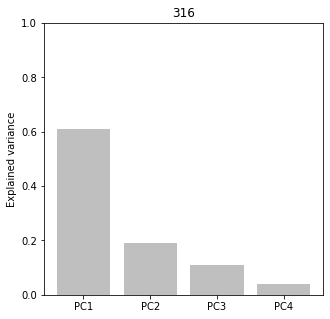

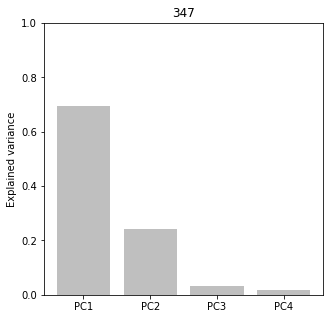

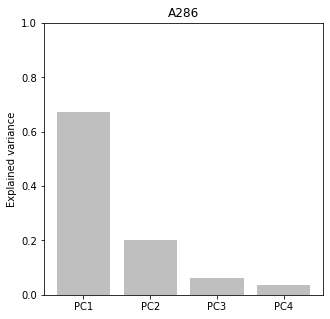

In [7]:
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_dr.drop(columns=['cold_work'],inplace=True)
    pca = PCA(n_components=4, svd_solver='full')
    pca.fit(subset_dr)
    plt.figure(figsize=(5, 5))
    plt.bar(["PC1","PC2","PC3","PC4"],pca.explained_variance_ratio_, align='center', alpha=0.5, color="gray")
    plt.ylim(0,1)
    plt.title(ind)
    plt.ylabel("Explained variance")

<Figure size 432x432 with 0 Axes>

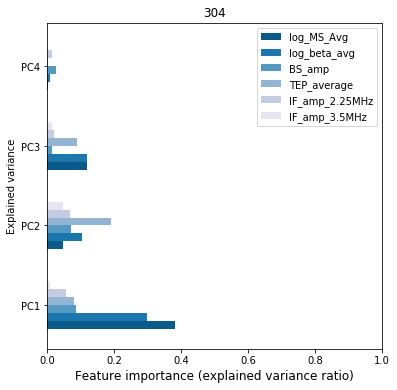

<Figure size 432x432 with 0 Axes>

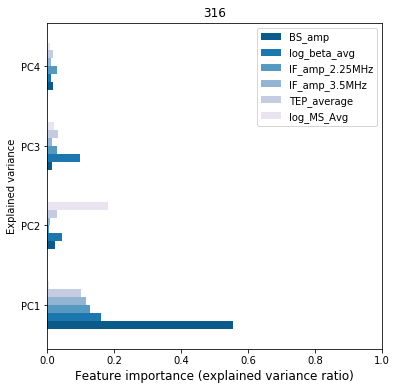

<Figure size 432x432 with 0 Axes>

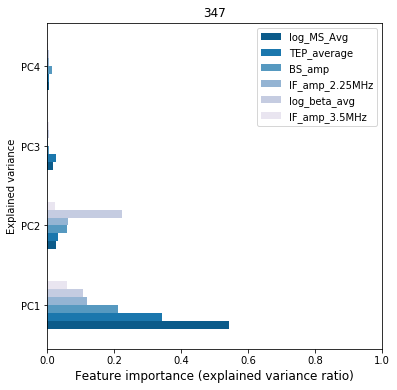

<Figure size 432x432 with 0 Axes>

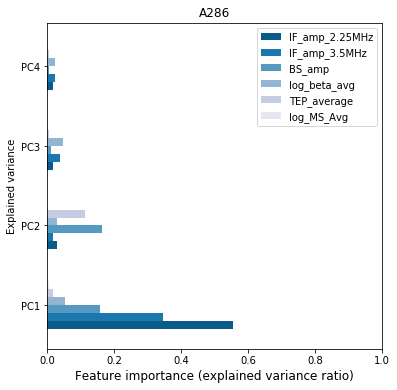

In [8]:
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_dr.drop(columns=['cold_work'],inplace=True)
    pca = PCA(n_components=4, svd_solver='full')
    pca.fit(subset_dr)
    plt.figure(figsize=(6, 6))
    feature_importance = pd.DataFrame([x*abs(y) for x,y in zip(pca.explained_variance_ratio_, pca.components_)],columns=subset_dr.columns, index=["PC1","PC2","PC3","PC4"] )
    plot_feat_imp = feature_importance.transpose().sort_values('PC1', ascending=False).transpose()
    plot_feat_imp.plot(kind='barh', color=sns.color_palette('PuBu_r', 6, desat=0.9), width=0.6, figsize=(6,6))
    plt.xlabel('Feature importance (explained variance ratio)', fontsize = 12)
    plt.xlim(0,1)
    plt.title(ind)
    plt.ylabel("Explained variance")